In [1]:
import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.5)

In [2]:
import sys

sys.path.insert(0,  '/home/was966/Research/mims-conceptor/')
from conceptor.utils import plot_embed_with_label
from conceptor import PreTrainer, FineTuner, loadconceptor #, get_minmal_epoch
from conceptor.utils import plot_embed_with_label, plot_performance, score2
from conceptor.tokenizer import CANCER_CODE
def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan].astype(bool)].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    cols = dfd.sum().sort_values(ascending=False).index.tolist()
    dfd = dfd[cols]
    return dfd

In [3]:
from conceptor.tokenizer import CONCEPT_palette

In [4]:
import shap
import torch
import torch.nn as nn
from shap import DeepExplainer
torch.manual_seed(0)

In [5]:
shap.__version__, np.__version__

('0.44.1', '1.24.3')

In [6]:
## load pretrainer
mfile = '/home/was966/Research/mims-conceptor/paper/checkpoint/latest/pretrainer.pt'
pretrainer = loadconceptor(mfile)

## read data
df_label = pd.read_pickle('/home/was966/Research/mims-conceptor/paper//00_data/ITRP.PATIENT.TABLE')
df_tpm = pd.read_pickle('/home/was966/Research/mims-conceptor/paper//00_data/ITRP.TPM.TABLE')
df_tpm.shape, df_label.shape

((1133, 15672), (1133, 110))

In [7]:
s = df_label.groupby('cohort').size()
cohorts = ['IMVigor210']

cohort_name = '_'.join(cohorts)
df_label = df_label[df_label.cohort.isin(cohorts)]

cancer_type = '_'.join(df_label.cancer_type.unique())
cohort_name = cancer_type + ':' + cohort_name

df_tpm = df_tpm.loc[df_label.index]
dfcx = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)
df_task = onehot(df_label.response_label)

In [8]:
finetuner = loadconceptor('./finetuner.pt', map_location='cpu')
device = finetuner.device

dfg, dfc = finetuner.extract(dfcx)
_, dfy = finetuner.predict(dfcx)

model = finetuner.model.taskdecoder
model.eval()

fname = dfc.columns[:-1]
x = torch.tensor(dfc[fname].values).to(device)

100%|##########| 1/1 [00:38<00:00, 38.10s/it]


In [9]:
x.shape

torch.Size([298, 45])

In [10]:
dfy.head()

,0,1
Index,,
IMVigor210-0257bb-ar-0257bbb,0.994455,0.005545
IMVigor210-025b45-ar-025b45c,0.990246,0.009754
IMVigor210-032c64-ar-032c642,0.976493,0.023507
IMVigor210-0571f1-ar-0571f17,0.924418,0.075582
IMVigor210-065890-ar-0658907,0.583311,0.416689


In [11]:
pd.DataFrame(model(torch.tensor(dfc.values[:,:-1], device=device)).cpu().detach().numpy())

,0,1
0,0.994455,0.005545
1,0.990246,0.009754
2,0.976493,0.023507
3,0.924418,0.075582
4,0.583311,0.416689
...,...,...
293,0.961329,0.038671
294,0.481676,0.518324
295,0.999593,0.000407
296,0.967892,0.032108


In [12]:
dfc[fname]

,CANCER,Adipocyte,Apoptosis_pathway,Bcell,CD4_Tcell,CD8_Tcell,CPI_Response,CPI_effect,Cytokine_chemokine,Cytotoxic_Tcell,...,Stem,Stroma,TGFb_pathway,TLS,TMB,Tcell_exclusion,Tcell_general,Treg,cDC,pDC
Index,,,,,,,,,,,,,,,,,,,,,
IMVigor210-0257bb-ar-0257bbb,0.302203,0.061174,0.348014,0.552395,0.652364,0.540151,0.471714,0.264389,0.435725,0.046278,...,0.295319,0.323428,0.583732,-0.028315,0.592733,0.627290,0.324497,0.149822,0.402294,0.397026
IMVigor210-025b45-ar-025b45c,0.302203,0.057370,0.329348,0.546646,0.547661,0.578201,0.479834,0.258406,0.455754,-0.038759,...,0.307610,0.177028,0.706860,-0.053493,0.547101,0.656886,0.297226,0.121892,0.435942,0.311668
IMVigor210-032c64-ar-032c642,0.302203,-0.030972,0.353642,0.496814,0.623591,0.518453,0.416025,0.289176,0.445585,0.193992,...,0.311289,0.365105,0.516833,-0.035628,0.612261,0.684748,0.452153,0.144523,0.468254,0.526107
IMVigor210-0571f1-ar-0571f17,0.302203,-0.033817,0.303061,0.488742,0.530690,0.541702,0.399707,0.413593,0.381909,0.198030,...,0.357667,0.351410,0.547159,0.197055,0.591857,0.608735,0.580629,0.187671,0.351575,0.434955
IMVigor210-065890-ar-0658907,0.302203,-0.012876,0.399609,0.530541,0.612472,0.515829,0.433983,0.267080,0.461083,0.091059,...,0.281346,0.428078,0.514578,-0.042912,0.569840,0.661268,0.362476,0.166921,0.365923,0.340147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IMVigor210-f82bbd-ar-f82bbdc,0.302204,0.045376,0.352303,0.549499,0.596937,0.544399,0.418293,0.286663,0.475585,-0.057820,...,0.295289,0.364343,0.531253,0.041563,0.581068,0.623085,0.303241,0.249559,0.422177,0.343113
IMVigor210-fb7aec-ar-fb7aec7,0.302203,-0.005621,0.367836,0.488528,0.587609,0.510273,0.401396,0.274599,0.432997,0.189591,...,0.329574,0.246361,0.580648,-0.019396,0.599694,0.600937,0.429480,0.153976,0.337772,0.353882
IMVigor210-fd9476-ar-fd94761,0.302203,0.034281,0.306731,0.546803,0.610889,0.526876,0.433742,0.272563,0.415845,-0.033909,...,0.317121,0.174535,0.697007,-0.020005,0.568468,0.685019,0.395705,0.166721,0.401751,0.332529


In [13]:
background = torch.zeros((1, len(fname))).to(device)
background.shape

torch.Size([1, 45])

In [14]:
# background = torch.tensor(dfc[fname].min().to_frame().values.reshape(1,-1)).to(device)
# background.shape

In [15]:
# background = x.mean(axis=0).reshape(1,-1)
# background.shape

In [16]:
# background = x
# background.shape

In [17]:
e = DeepExplainer(model, background)
shap_values = e.shap_values(x, check_additivity=False)

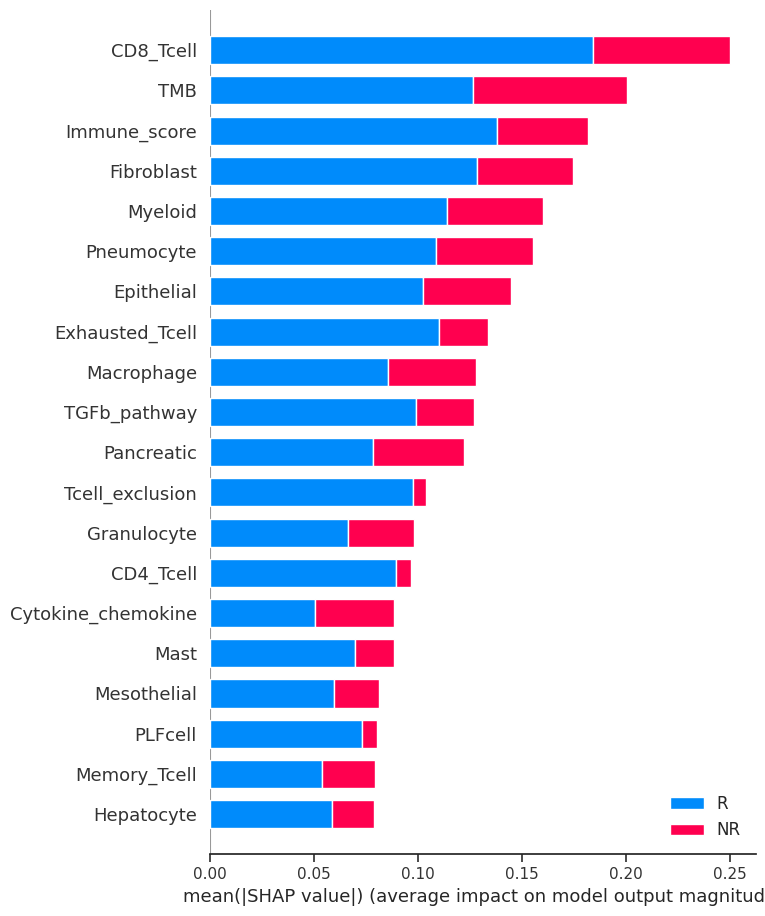

In [18]:
shap.summary_plot(shap_values, x.numpy(), feature_names = fname, class_names = {0:'NR', 1:'R'}, max_display = 20)

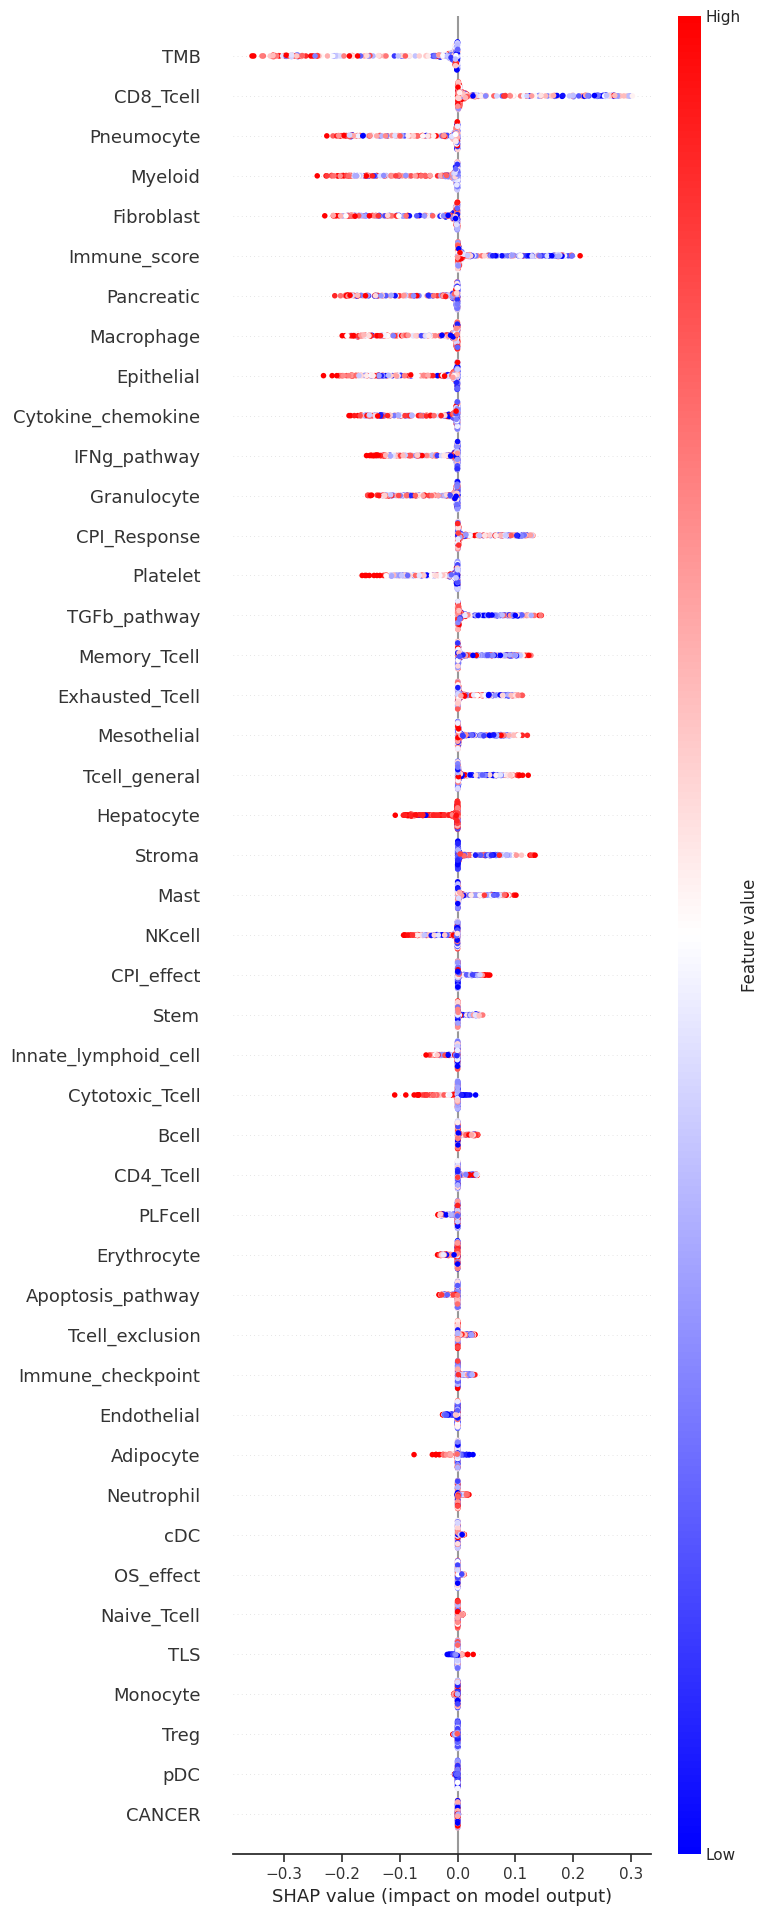

In [21]:
shap.summary_plot(shap_values[0], x.numpy(), feature_names = fname, cmap='bwr', plot_type='dot', class_names = {0:'NR', 1:'R'}, max_display = 45)

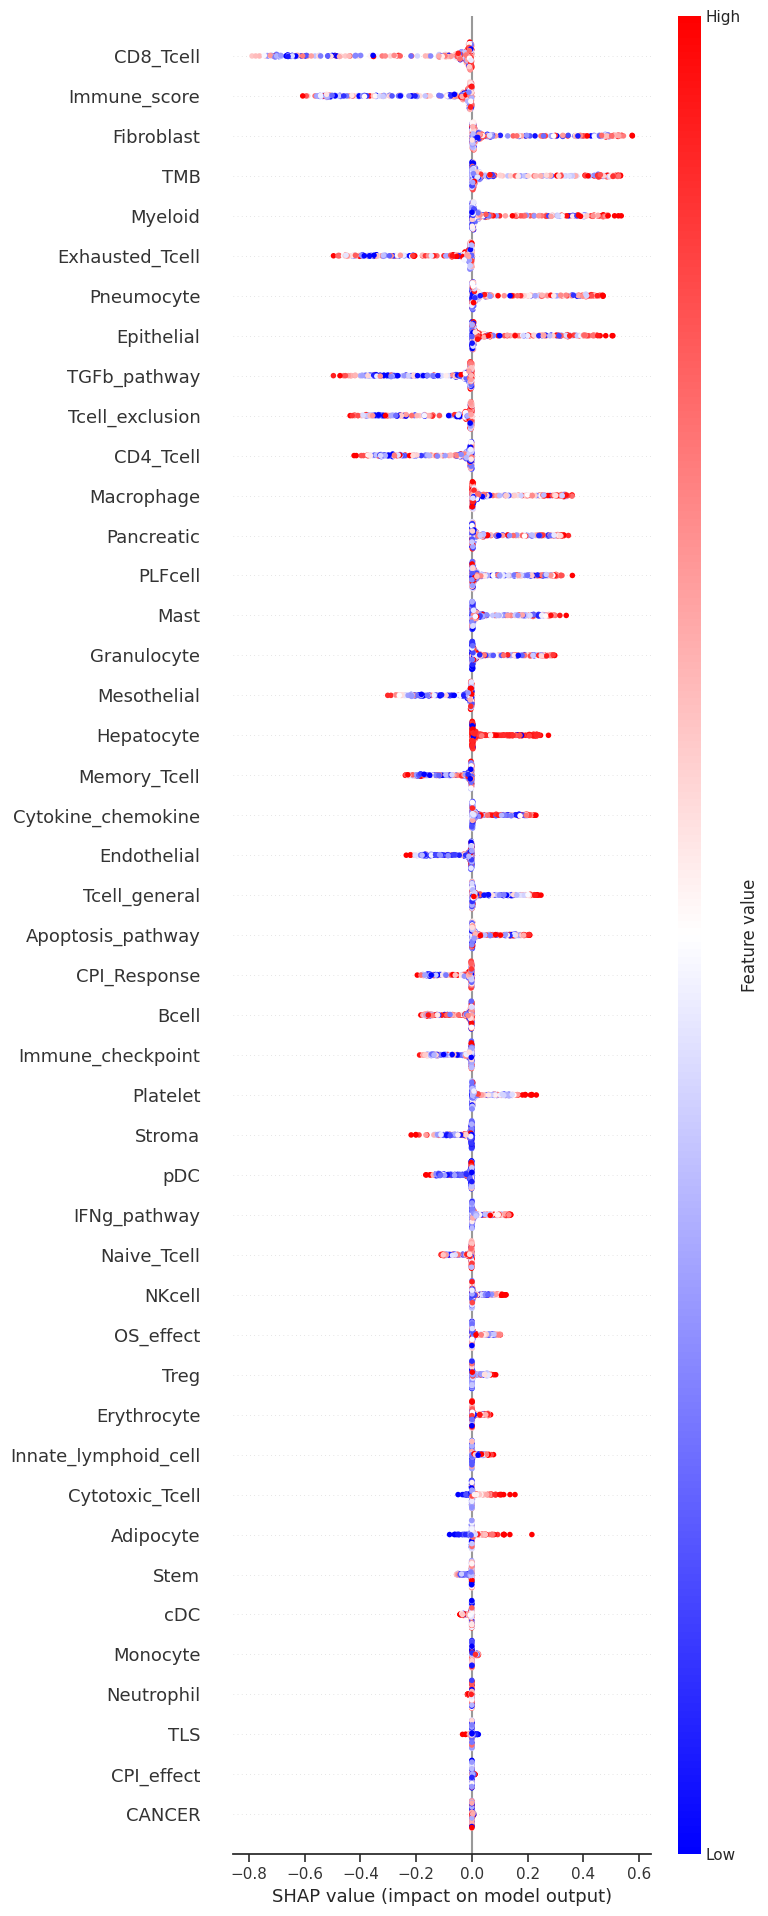

In [22]:
shap.summary_plot(shap_values[1], x.numpy(), feature_names = fname, cmap='bwr', plot_type='dot', class_names = {0:'NR', 1:'R'}, max_display = 45)

In [45]:
df1 = pd.DataFrame(shap_values[1], columns = fname, index=dfcx.index)
df1.to_csv('shap_fft_r.csv')